## TradingEnv-v0

### Open AI 'Gym' for reinforcement-learning based trading algorithms

This gym implements a very simple trading environment for reinforcement learning.

The gym provides daily observations based on real market data pulled from Quandl on, by default, the SPY etf.  An episode is defined as 252 contiguous days sampled from the overall dataset.  Each day is one 'step' within the gym and for each step, the algo has a choice:

 - SHORT (0)
 - FLAT (1)
 - LONG  (2)
 
If you trade, you will be charged, by default, 10 BPS of the size of your trade.  Thus, going from short to long costs twice as much as going from short to/from flat.  Not trading also has a default cost of 1 BPS per step.  Nobody said it would be easy!
 
At the beginning of your episode, you are allocated 1 unit of cash.  This is your starting Net Asset Value (NAV). If your NAV drops to 0, your episode is over and you lose.  If your NAV hits 2.0, then you win.

At this point, I'm still figuring out what an appropriate condition for 'solved' would be in the context of OpenAI's 'Universe'... 

### Below, we look at some code using the environment


###  imports

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)


### create the environment

This may take a moment as we are pulling historical data from quandl.

In [2]:
env = gym.make('trading-v0')
#env.time_cost_bps = 0 # 


[2016-12-14 10:40:08,978] Making new env: trading-v0
[2016-12-14 10:40:08,990] gym.envs.classic_control.trading_env logger started.
[2016-12-14 10:40:08,991] getting data for GOOG/NYSE_SPY from quandl...
[2016-12-14 10:40:11,032] got data for GOOG/NYSE_SPY from quandl...


### the trading model

Each time step is a day.  Each episode is 252 trading days - a year.  Each day, we can choose to be short (-1), flat (0) or long (1) the single instrument in our trading universe.

Let's run through a day and stay flat.

Annualized return:  -0.0247888380589


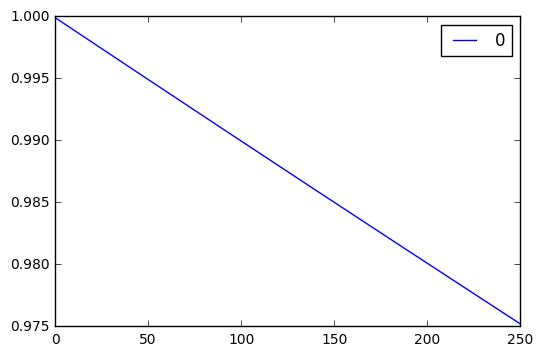

In [3]:
observation = env.reset()
done = False
navs = []
while not done:
    action = 1 # stay flat
    observation, reward, done, info = env.step(action)
    navs.append(info['nav'])
    if done:
        print 'Annualized return: ',navs[len(navs)-1]-1
        pd.DataFrame(navs).plot()


Note that you are punished for not trading - to the tune of 1 basis point per day


### buying & holding will yield variable results as the data varies...

Annualized return:  0.0252589744042
Annualized return:  -0.0887828917262
Annualized return:  0.192999382433


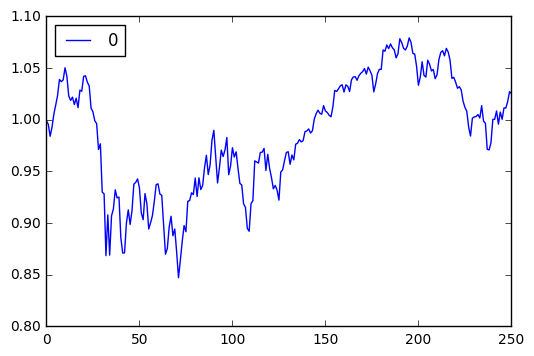

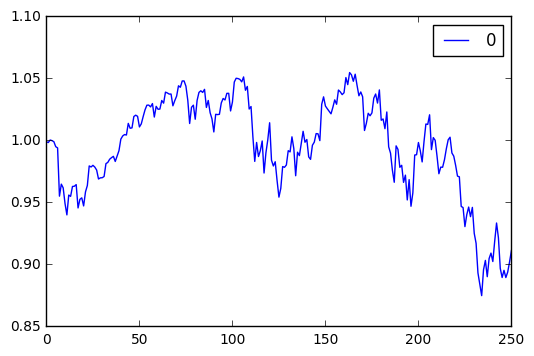

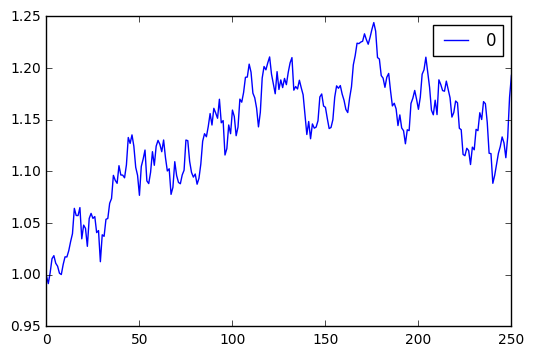

In [4]:
Episodes=3
for _ in range(Episodes):
    observation = env.reset()
    done = False
    navs = []
    while not done:
        action = 2 # buy & hold
        observation, reward, done, info = env.step(action)
        #print observation,reward,done,info
        navs.append(info['nav'])
        if done:
            print 'Annualized return: ',navs[len(navs)-1]-1
            pd.DataFrame(navs).plot()



###  as will randomly trading, but with much higher costs...

Annualized return:  -0.297277999126
Annualized return:  -0.232598388688
Annualized return:  -0.290342271555


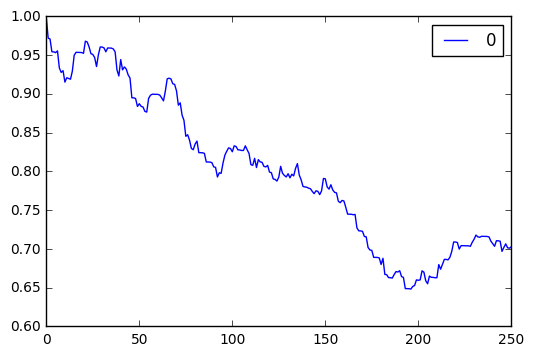

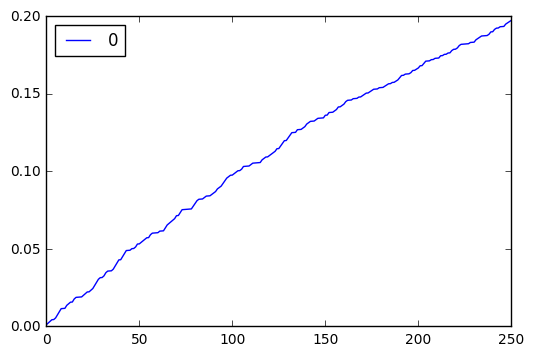

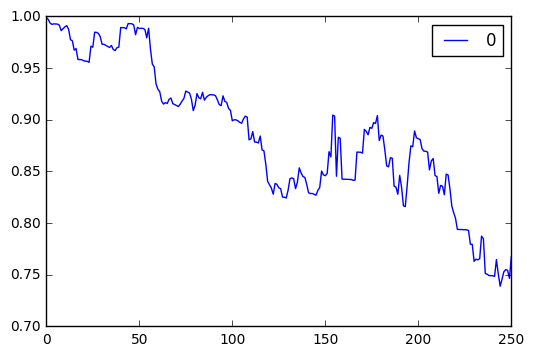

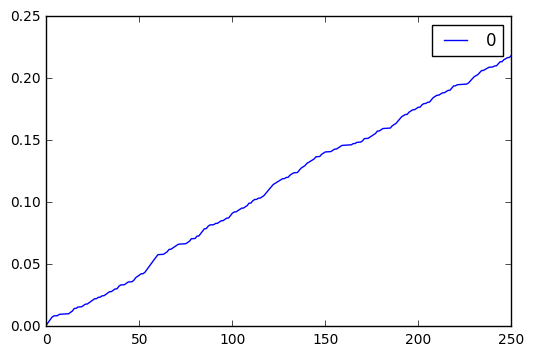

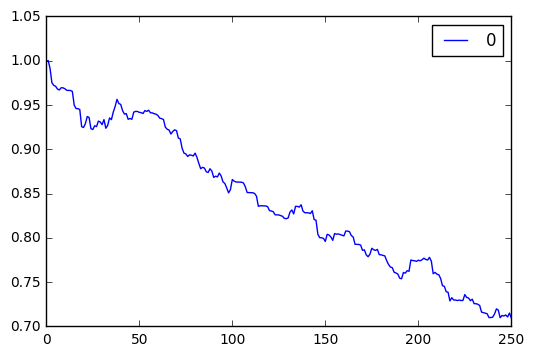

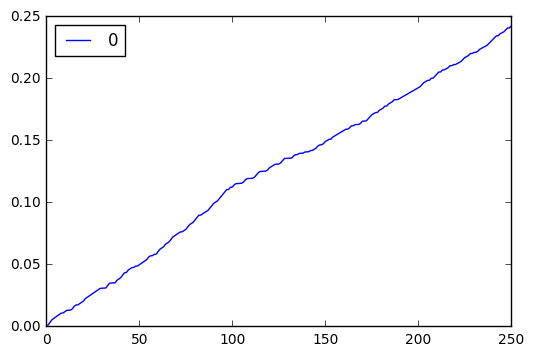

In [5]:
Episodes=3
for _ in range(Episodes):
    observation = env.reset()
    done = False
    navs = []
    costs = []
    while not done:
        action = env.action_space.sample() # random acts of trading
        observation, reward, done, info = env.step(action)
        #print observation,reward,done,info
        navs.append(info['nav'])
        costs.append(info['costs_bps'])
        if done:
            print 'Annualized return: ',navs[len(navs)-1]-1
            pd.DataFrame(navs).plot()
            pd.DataFrame(costs).cumsum().plot()

## Rendering?

For now, no rendering has been implemented for this gym, but with each step, the following datum are provided which you can easily graph and otherwise visualize as we see above with the NAV:

 - daypnl - how much did we make or lose between yesterday and today?
 - costs  - how much did we pay in costs (in bps) today
 - nav    - our current nav
 